In [1]:
%matplotlib inline
import numpy as np
from tabulate import tabulate
from scipy import stats, special, signal
from matplotlib import pyplot as plt

## (remove later) So in this lab we will assume that we know the form of the signal-free background distribution (determining a distribution from data will be next week's lab). In each of our three examples, your task will be to state the statistical question, convert it to math, then perform the associated analyses.

# Problem 1

## Environmental factors influence the reliability of our experimental data. In the following situation, the experiment works best in a 12 Kelvin environment, where our thermometer has a 0.4 degree precision. Hypothetically, the thermometer may give anomalously high and low temperature readings. In these cases, it is best to be cautious and throw these data points out, even if the true temperature was fine and the thermometer had glitched.

## We can now simulate 100k data points with Gaussian fluctuations and manually add 8 'bad' data points.

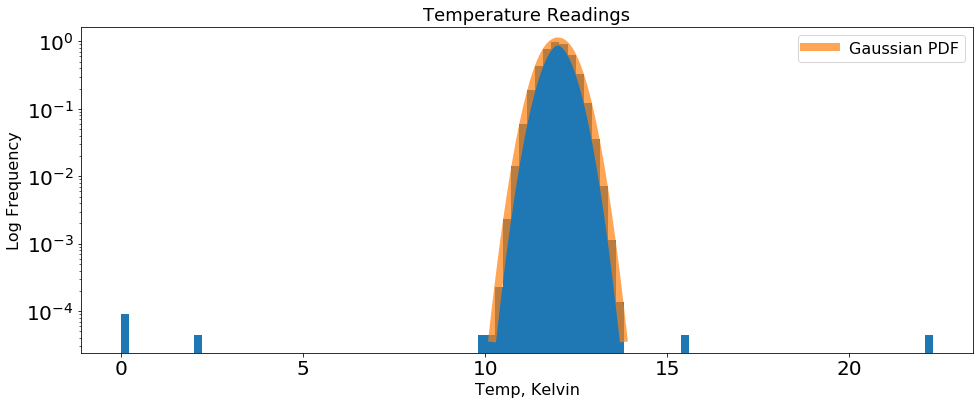

In [2]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

bad = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), bad)

ax.hist(d,100, density=True)

x = np.linspace(10.2,13.8,1000)
ax.plot(x,stats.norm.pdf(x,loc = 12., scale = 0.4),linewidth = 8,alpha = 0.7,label='Gaussian PDF')

ax.set_title("Temperature Readings", fontsize=18)
ax.set_xlabel("Temp, Kelvin", fontsize=16)
ax.set_ylabel("Log Frequency", fontsize=16)

plt.tick_params(labelsize = 20)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()

## The statistical question I want to ask is, what is the probability that my data points should be considered anomalies? (This is an important question, and implies a necessity for a statistical test that can distinguish between points drawn from our signal-free background distribution, and points that occur from error).

## In math, this looks like PPF of $P(x) = \int_{x}^{\infty} PDF(x) dx$ where x is temperature and our PDF is Gaussian of mean 12 and scale 0.4; throw out if PPF of x $ > 5 \sigma$ 

In [8]:
#truth table shit

thresh = 5.
bad = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), bad)
interval = [12-0.4*thresh,12+0.4*thresh]

print("The interval of temperature inside 5 sigma is [{0:.3f},{1:.3f}] degrees. Anything outside should be thrown out.\n".format(interval[0],interval[1]))

good = []
bad = []

for i in range(len(d)):
    if d[i] <= interval[0]:
        bad.append(d[i])
    if d[i] >= interval[1]:
        bad.append(d[i])
    if interval[0] < d[i] < interval[1]:
        good.append(d[i])

print(tabulate([['Sorted Good', 100000, len(good)-100000], ['Sorted Bad', 0, len(bad)]], headers=['','True Good', 'True Bad']))

The interval of temperature inside 5 sigma is [10.000,14.000] degrees. Anything outside should be thrown out.

               True Good    True Bad
-----------  -----------  ----------
Sorted Good       100000           2
Sorted Bad             0           6


### The number of omissions (in which we throw out good data) depends on the threshold chosen. In this case, we chose 5 sigma, and there aren't any instances of good data being thrown out. If we chose a different threshold, then the amount of good data thrown out is predictably reliant upon the amount of data within the chosen threshold.

### There are mistakes of commission - 2 of them, where the bad data points are 10.3 and 12.7. We would have to choose a threshold that excludes values 0.7 away from the mean or more (to ensure that 12.7 is thrown out). This corresponds to a sigma of (0.7)/(0.4) = 1.75. The distribution would look like:

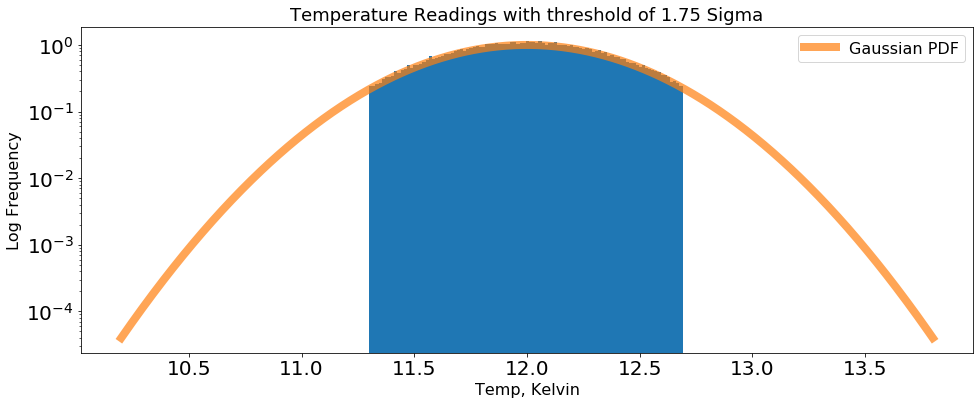

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

new = []
for i in range(len(d)):
    if 11.3 < d[i] < 12.69:
        new.append(d[i])

ax.hist(new,100, density=True)

x = np.linspace(10.2,13.8,1000)
ax.plot(x,stats.norm.pdf(x,loc = 12., scale = 0.4),linewidth = 8,alpha = 0.7,label='Gaussian PDF')

ax.set_title("Temperature Readings with threshold of 1.75 Sigma", fontsize=18)
ax.set_xlabel("Temp, Kelvin", fontsize=16)
ax.set_ylabel("Log Frequency", fontsize=16)

plt.tick_params(labelsize = 20)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()

# Problem 2

### When looking for asteroids, atmospheric and instrumental noise follow a 2D Gaussian with 1 arcsecond root-mean-square (RMS), quantifying the distribution that models how far the stars in the background appear to move across the images we take. That histogram looks like:

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14,14)

a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);

ax.set_aspect('equal', 'box')

plt.xlim([-4 , 4])
plt.ylim([-4 , 4])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)

plt.colorbar(h[3], ax=ax)
plt.show()

### An asteroid would have some movement between images that is of higher significance than the noise shown above. Our statistical question in words is, what is the distance corresponding to a $5\sigma$ signal from our background distribution?

### In math, this looks like PPF of $P(x,y) = \int_{x}^{\infty} PDF(x)dx \int_{y}^{\infty} PDF(y)dy$ where x and y correspond to the coordinate of a possible asteroid on the sky, in which the distance would be $\sqrt{x^{2}+y^{2}}$ and the PDFs are identical Gaussians with mean=0 and std=1... since they are identical, it is easier to say y=x and the distance = $\sqrt{2}x$.... finally, find the distance that has PPF $ > 5 \sigma$

In [10]:
x,y = np.linspace(0,8,100),np.linspace(0,8,100)
pdfx,pdfy = stats.norm.pdf(x),stats.norm.pdf(y)
ppf,p = np.empty(len(x)),np.empty(len(x))

for i in range(len(x)):
    p[i] = (sum(pdfx[i:]))*sum(pdfy[i:])
    ppf[i] = stats.norm.ppf(1-p[i])
    if ppf[i] > 5.0:
        smallestx = x[i]
        break

d = np.sqrt(2.)*smallestx

print("\nThe distance corresponding to 5 sigma is {0:.5f} arcseconds.".format(d))


The distance corresponding to 5 sigma is 5.71399 arcseconds.


# Problem 3

### In an experiment in which we are looking for gamma-rays, cosmic rays are the main source of noise. The moon actually absorbs and re-emits (in a decreased amount) signals which can be interpreted as cosmic ray events. In this experiment, we want to characterize the signal coming from the moon's shadow and relate it to our cosmic ray background distribution. 

### We assume an average of 1 cosmic ray per minute in normal circumstances. They follow a poisson distribution, so for 15 days of 8 hr observing periods, we convolve that poisson and are left with a poisson of mean=7200. In our observation of the moon, we see 6800 cosmic rays.

### Our question is, what is the probability that the signals received from the moon's shadow are from our cosmic ray background distribution?

### In math, this is PPF of $Prob(x) = \Sigma_{x}^{\infty} PMF(x)dx$ where x is the number of events, PMF is our Poisson with mean=7200.

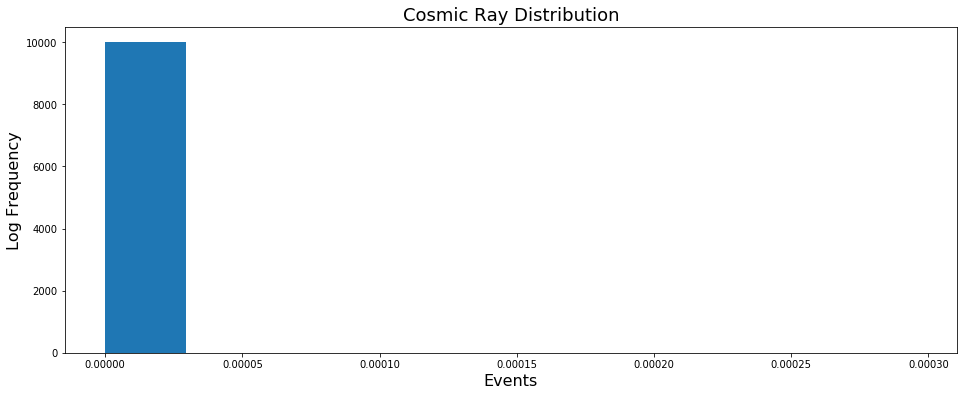

In [15]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

g = np.linspace(6600,7800,10000)
pmf = stats.poisson.pmf(g,mu=7200)

ax.hist(pmf)#,density=True)

ax.set_title("Cosmic Ray Distribution", fontsize=18)
ax.set_xlabel("Events", fontsize=16)
ax.set_ylabel("Log Frequency", fontsize=16)

#plt.tick_params(labelsize = 20)
#plt.yscale('log')
#plt.legend(fontsize=16)
plt.show()

halp